In [1]:
import os, math
from collections import defaultdict
import itertools
import sqlite3

import logging
import logging.handlers

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
RNG = np.random.default_rng()

In [3]:
x = RNG.integers(10, size=16).reshape(4,4)
x

array([[7, 3, 0, 5],
       [5, 2, 8, 3],
       [3, 5, 2, 2],
       [4, 9, 8, 7]])

In [4]:
xa1 = np.max(x, axis=1)
xa1

array([7, 8, 5, 9])

In [5]:
xa2 = np.sum(x, axis=1)
xa2

array([15, 18, 12, 28])

In [6]:
np.argsort(-xa1)

array([3, 1, 0, 2])

In [7]:
np.argsort(-xa2)

array([3, 1, 0, 2])

In [8]:
l = [10, 20, 10, 1, 2]
np.unique_counts(l)

UniqueCountsResult(values=array([ 1,  2, 10, 20]), counts=array([1, 1, 2, 1]))

In [9]:
v = 723
f'{v:5}'

'  723'

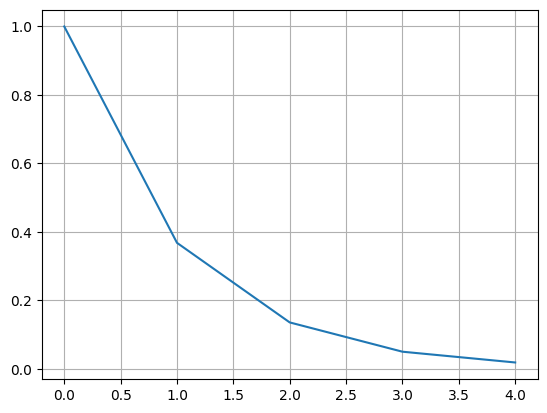

,x,y
0,0.0,1.000000
1,1.0,0.367879
2,2.0,0.135335
3,3.0,0.049787
4,4.0,0.018316


In [10]:
l = 1
xs = list(range(5))
ys = []
df = pd.DataFrame(columns=['x', 'y'])

for x in xs:
    y = l * np.exp(-l * x)
    ys.append(y)
    df.loc[len(df)] = [x, y]

plt.plot(xs, ys)
plt.grid()
plt.show()

df

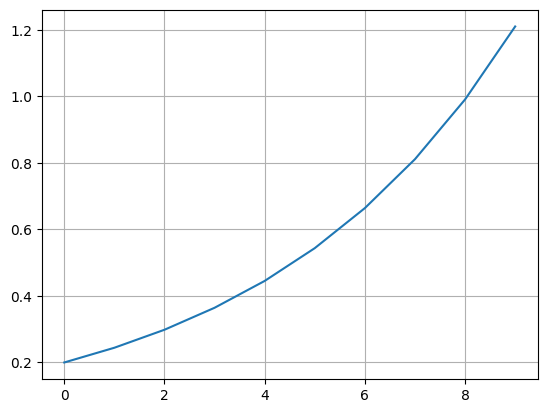

,x,y
0,0.0,0.200000
1,1.0,0.244281
2,2.0,0.298365
3,3.0,0.364424
4,4.0,0.445108
5,5.0,0.543656
6,6.0,0.664023
7,7.0,0.811040
8,8.0,0.990606
9,9.0,1.209929


In [11]:
l = 0.2
xs = list(range(10))
ys = []
df = pd.DataFrame(columns=['x', 'y'])

for x in xs:
    y = l * np.exp(l * x)
    ys.append(y)
    df.loc[len(df)] = [x, y]

plt.plot(xs, ys)
plt.grid()
plt.show()

df

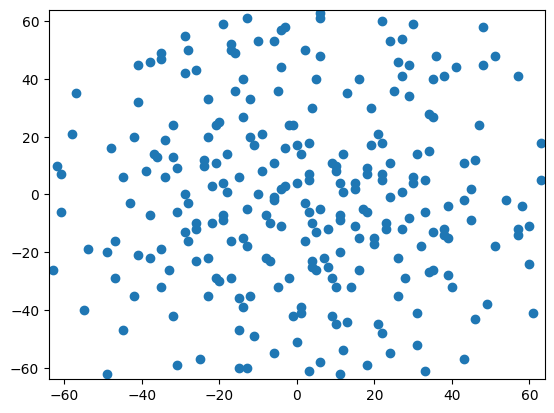

(256, 256, np.int64(-63), np.int64(63), np.int64(-62), np.int64(63))

In [160]:
mean = [0, 0]
# cov = [[1, 0], [0, 100]]  # diagonal covariance
cov = [[64, 0], [0, 64]]  # spherical covariance
xs, ys = np.random.multivariate_normal(mean, cov, 10000).T * 4
xs = xs[(xs >= -64) & (xs <= 64)].astype(int)
ys = ys[(ys >= -64) & (ys <= 64)].astype(int)
unique_xy_pairs = set()

for x, y in zip(xs, ys):
    unique_xy_pairs.add((x, y))

xs = list(map(lambda xy_pair: xy_pair[0], unique_xy_pairs))[:256]
ys = list(map(lambda xy_pair: xy_pair[1], unique_xy_pairs))[:256]


plt.scatter(xs, ys)
plt.ylim(-64, 64)
plt.xlim(-64, 64)
# plt.axis('equal')
plt.show()
len(xs), len(ys), np.min(xs), np.max(xs), np.min(ys), np.max(ys)